In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [22]:
from device import device

In [20]:
from utils import load_video_frames, img_display, img_save

In [18]:
video_path = 'videos/ian-mini.mp4'
loaded_frames = load_video_frames(video_path)
print(f"Loaded {len(loaded_frames)} frames of dimensions {loaded_frames[0].shape}.")

Loaded 300 frames of dimensions torch.Size([640, 300, 3]).


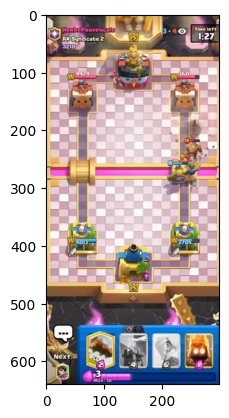

In [21]:
img_display(loaded_frames[0])

In [7]:
frame_area = frame_width * frame_height
frame_volume = frame_area * frame_channels

chunk_area = chunk_width * chunk_height
chunk_volume = chunk_area * frame_channels

frame_width_chunks = frame_width / (chunk_width / 2) - 1
frame_height_chunks = frame_height / (chunk_height / 2) - 1

assert(frame_width_chunks == int(frame_width_chunks))
assert(frame_height_chunks == int(frame_height_chunks))

frame_width_chunks = int(frame_width_chunks)
frame_height_chunks = int(frame_height_chunks)
frame_area_chunks = frame_width_chunks * frame_height_chunks

print(f"Frame area: {frame_area}")
print(f"Frame volume: {frame_volume}")
print(f"Chunkified volume: {hidden_channels * frame_area_chunks}")

print(f"Chunk area: {chunk_area}")
print(f"Chunk volume: {chunk_volume}")

print(f"Frame width chunks: {frame_width_chunks}")
print(f"Frame height chunks: {frame_height_chunks}")
print(f"Frame area chunks: {frame_area_chunks}")


Frame area: 192000
Frame volume: 576000
Chunkified volume: 116928
Chunk area: 400
Chunk volume: 1200
Frame width chunks: 29
Frame height chunks: 63
Frame area chunks: 1827


In [14]:
class SimulatorHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.keymaker = nn.Linear(hidden_channels, attention_channels)
        self.querymaker = nn.Linear(hidden_channels, attention_channels)
        self.valuemaker = nn.Linear(hidden_channels, hidden_channels)
        self.position_biases = nn.Parameter(torch.normal(0, 1, (frame_area_chunks, frame_area_chunks)))

    def forward(self, encoded_frames):
        batch_size = encoded_frames.shape[0]

        encoded_frames = encoded_frames.reshape(batch_size, frame_area_chunks, hidden_channels)

        keys = self.keymaker(encoded_frames)
        queries = self.querymaker(encoded_frames)
        values = self.valuemaker(encoded_frames)

        keys = nn.functional.relu(keys)
        queries = nn.functional.relu(queries)
        values = nn.functional.relu(values)

        weights = torch.bmm(queries, keys.permute(0, 2, 1)) + self.position_biases

        weights = weights.reshape(batch_size, frame_area_chunks, frame_area_chunks, 1)
        values = values.reshape(batch_size, 1, frame_area_chunks, hidden_channels)

        outputs = weights * values
        outputs = nn.functional.relu(outputs)

        outputs = torch.sum(outputs, dim=-2)
        outputs = outputs.reshape(batch_size, frame_height_chunks, frame_width_chunks, hidden_channels)

        return outputs

class SimulatorBlock(nn.Module):
    def __init__(self, num_heads):
        super().__init__()

        self.heads = nn.ModuleList([SimulatorHead() for _ in range(num_heads)])
        self.dense = nn.Linear(hidden_channels, hidden_channels)

    def forward(self, frame):

        for head in self.heads:
            frame = frame + head(frame)

        frame = self.dense(frame)
        frame = nn.functional.relu(frame)

        return frame
    
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(frame_channels, hidden_channels, (chunk_height, chunk_width), stride=(chunk_height // 2, chunk_width // 2), padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, (chunk_height, chunk_width), stride=1, padding=0),
            nn.ReLU(),
        )

    def forward(self, frames):

        frames = frames.permute(0, 3, 1, 2)
        frames = self.encoder(frames)    
        
        frames = frames.permute(0, 2, 3, 1)

        return frames


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_channels, hidden_channels, (chunk_height, chunk_width), stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, frame_channels, (chunk_height, chunk_width), stride=(chunk_height // 2, chunk_width // 2), padding=0),
        )

    def forward(self, frames):

        frames = frames.permute(0, 3, 1, 2)
        frames = self.decoder(frames)
        frames = frames.permute(0, 2, 3, 1)
        frames /= 100

        return frames
    

class Simulator(nn.Module):
    def __init__(self, num_blocks, num_heads):
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()
        
        self.blocks = nn.ModuleList([SimulatorBlock(num_heads) for _ in range(num_blocks)])

    def autoencode(self, frames):
        frames = self.encoder(frames)
        frames = self.decoder(frames)
        return frames

    def forward(self, frames):

        deltas = self.encoder(frames)

        for block in self.blocks:
            deltas = deltas + block(deltas)

        deltas = self.decoder(deltas)

        return frames + deltas


In [15]:
simulator = Simulator(0, 0).to(device)

num_params = sum(parameter.numel() for parameter in simulator.parameters())

print(num_params, "params")
print(num_params * 4 / 1024 / 1024, "MB")

3430595 params
13.086681365966797 MB


In [16]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, frames):
        self.frames = frames

    def __len__(self):
        return len(self.frames) - 1

    def __getitem__(self, idx):
        current_frame = self.frames[idx]
        next_frame = self.frames[idx + 1]
        return current_frame, next_frame

In [12]:
dataset = VideoDataset(loaded_frames)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.AdamW(simulator.parameters(), lr=3e-4)

num_epochs = 100

for epoch in range(num_epochs):
    simulator.train()
    running_loss = 0.0

    for batch_idx, (current_frames, next_frames) in enumerate(dataloader):
        current_frames = current_frames.to(device)
        next_frames = next_frames.to(device)

        optimizer.zero_grad()

        outputs = simulator(current_frames)

        assert(outputs.shape == next_frames.shape)

        print(outputs.mean().item(), next_frames.mean().item())
        
        loss = criterion(outputs, next_frames)

        loss.backward()

        optimizer.step()

        # for name, param in simulator.named_parameters():
        #     if param.requires_grad:
        #         print(f"Gradient of {name}:")
        #         print(param.grad)

        running_loss += loss.item()
        if batch_idx % 10 == 9:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

    if epoch % 1 == 0:
        imsave(current_frames[0], 'input.png')
        imsave(outputs[0], 'output.png')
        imsave(next_frames[0], 'output-expected.png')

print("Training completed")

0.606338381767273 0.6071007251739502
0.6041892170906067 0.6032010912895203
0.6008281111717224 0.5996705293655396
0.6005844473838806 0.6021080017089844
0.6029143333435059 0.6025844216346741
0.6023119688034058 0.6027326583862305
0.603359043598175 0.6035488843917847
0.6037970185279846 0.6039491891860962
0.6030290722846985 0.6029408574104309
0.6034402847290039 0.6042232513427734
Epoch [1/100], Batch [10/75], Loss: 0.0012
0.6035187244415283 0.6028434038162231
0.6031999588012695 0.6032306551933289
0.6021168231964111 0.6022695302963257
0.6033048629760742 0.6037774085998535
0.6033120155334473 0.6036979556083679
0.6041740775108337 0.5976000428199768
0.5873140096664429 0.5863316655158997
0.5738397240638733 0.5784288644790649
0.5970754027366638 0.5995227098464966
0.6052542924880981 0.6069326400756836
Epoch [1/100], Batch [20/75], Loss: 0.0030
0.5903844237327576 0.5830822587013245
0.589788556098938 0.5898797512054443
0.5778900980949402 0.5773757696151733
0.5755453705787659 0.5757262706756592
0.576

KeyboardInterrupt: 

In [ ]:
assert(False)

AssertionError: 

In [ ]:
def generate_frames(initial_frame, num_frames=50):
    simulator.eval()
    generated_frames = [initial_frame]
    current_frame = initial_frame

    with torch.no_grad():
        for _ in range(num_frames - 1):
            current_frame = current_frame.unsqueeze(0)  # Add batch dimension
            next_frame = simulator(current_frame).squeeze(0)  # Remove batch dimension
            generated_frames.append(next_frame)
            current_frame = next_frame

    return torch.stack(generated_frames)

def write_video(frames, output_filename, fps = 2):

    if type(frames) == torch.Tensor:
        frames = np.array(frames.detach().cpu())

    frames = (np.array(frames) * 255).astype(np.uint8)
    frames = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) for frame in frames])

    if frames.ndim != 4 or frames.shape[3] != 3:
        raise ValueError("Input frames should be a 4D numpy array with shape (N, frame_height, frame_width, 3).")

    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))

    for frame in frames:
        out.write(frame)

    out.release()

In [ ]:
initial_frame = loaded_frames[0].to(device)
generated_frames = generate_frames(initial_frame)

write_video(generated_frames, 'generated_video.mp4')

In [ ]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="generated_video.mp4" type="video/mp4">
    </video>
""")